In [21]:
import tensorflow
tensorflow.__version__

'2.8.0'

# Understanding recurrent neural networks

This notebook contains the code samples found in Chapter 6, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---

[...]

## A first recurrent layer in Keras

The process we just naively implemented in Numpy corresponds to an actual Keras layer: the `SimpleRNN` layer:


In [22]:
from tensorflow.keras.layers import SimpleRNN

There is just one minor difference: `SimpleRNN` processes batches of sequences, like all other Keras layers, not just a single sequence like 
in our Numpy example. This means that it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps, 
input_features)`.

Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive 
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each 
input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor 
argument. Let's take a look at an example:

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))  # Die Länge der Sequenzen muss nicht übergeben werden
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [25]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. 
In such a setup, you have to get all intermediate layers to return full sequences:

In [26]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, None, 32)          2080      
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, None, 32)          2080      
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, None, 32)          2080      
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 32)                2080      
                                                                 
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

In [27]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [28]:
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 19s 113ms/step - loss: 0.5843 - acc: 0.6763 - val_loss: 0.4202 - val_acc: 0.8180
Epoch 2/10
157/157 [==============================] - 17s 111ms/step - loss: 0.3616 - acc: 0.8518 - val_loss: 0.4628 - val_acc: 0.7778
Epoch 3/10
157/157 [==============================] - 18s 113ms/step - loss: 0.2826 - acc: 0.8881 - val_loss: 0.4330 - val_acc: 0.7972
Epoch 4/10
157/157 [==============================] - 18s 116ms/step - loss: 0.2340 - acc: 0.9111 - val_loss: 0.3438 - val_acc: 0.8498
Epoch 5/10
157/157 [==============================] - 26s 163ms/step - loss: 0.1823 - acc: 0.9337 - val_loss: 0.3766 - val_acc: 0.8494
Epoch 6/10
157/157 [==============================] - 23s 144ms/step - loss: 0.1589 - acc: 0.9438 - val_loss: 0.3717 - val_acc: 0.8682
Epoch 7/10
157/157 [==============================] - 19s 121ms/step - loss: 0.1188 - acc: 0.9572 - val_loss: 0.3926 - val_acc: 0.8612
Epoch 8/10
157/157 [==============================] - 1

Let's display the training and validation loss and accuracy:

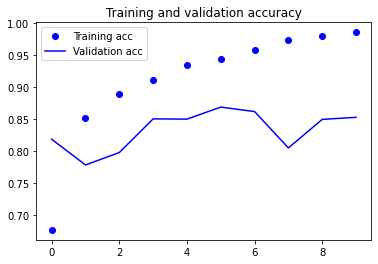

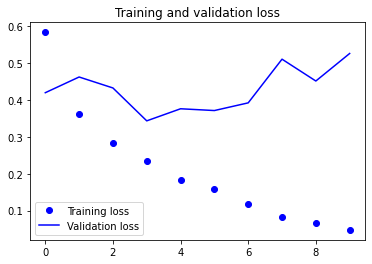

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As a reminder, in chapter 3, our very first naive approach to this very dataset got us to 88% test accuracy. Unfortunately, our small 
recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is 
that our inputs only consider the first 500 words rather the full sequences -- 
hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some 
more advanced layers.

[...]

## A concrete LSTM example in Keras

Now let's switch to more practical concerns: we will set up a model using a LSTM layer and train it on the IMDB data. Here's the network, 
similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every 
other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you 
having to spend time tuning parameters by hand.

In [30]:
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 35s 209ms/step - loss: 0.5471 - acc: 0.7481 - val_loss: 0.4009 - val_acc: 0.8336
Epoch 2/10
157/157 [==============================] - 33s 208ms/step - loss: 0.3145 - acc: 0.8749 - val_loss: 0.3815 - val_acc: 0.8368
Epoch 3/10
157/157 [==============================] - 35s 225ms/step - loss: 0.2416 - acc: 0.9076 - val_loss: 0.3550 - val_acc: 0.8426
Epoch 4/10
157/157 [==============================] - 38s 242ms/step - loss: 0.2072 - acc: 0.9234 - val_loss: 0.3332 - val_acc: 0.8590
Epoch 5/10
157/157 [==============================] - 34s 219ms/step - loss: 0.1791 - acc: 0.9352 - val_loss: 0.3687 - val_acc: 0.8818
Epoch 6/10
157/157 [==============================] - 35s 222ms/step - loss: 0.1586 - acc: 0.9436 - val_loss: 0.4697 - val_acc: 0.8388
Epoch 7/10
157/157 [==============================] - 39s 249ms/step - loss: 0.1461 - acc: 0.9478 - val_loss: 0.4090 - val_acc: 0.8622
Epoch 8/10
157/157 [==============================] - 3

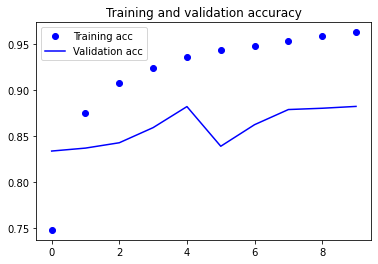

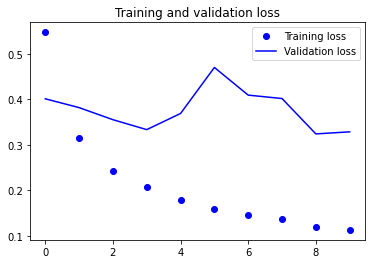

In [31]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Übung:
* Um beim Definieren und Trainieren eines LSTMs ein bisschen muscle memory zu entwickeln, schauen wir uns wieder den reuters-Datensatz an. Vielleicht können wir unser vorgestriges Ergebnis mit LSTMs schlagen?

In [16]:
from keras.datasets import reuters
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = reuters.load_data(num_words=max_features)
print(input_train.shape, 'train sequences')
print(input_test.shape, 'test sequences')

Loading data...
(8982,) train sequences
(2246,) test sequences


In [17]:
print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Pad sequences (samples x time)
input_train shape: (8982, 500)
input_test shape: (2246, 500)


# Lösung:

In [33]:
from keras.layers import LSTM, Flatten

model = Sequential()
model.add(Embedding(max_features, 16, input_length=maxlen))
model.add(LSTM(16,dropout=0.2,recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(16,dropout=0.2,recurrent_dropout=0.2, return_sequences=True))
model.add(Flatten())         # Eine Alternative: Wir setzen das Klassifizierungslayer auf eine volle Sequenz
model.add(Dense(64, activation='relu'))
model.add(Dense(46, activation='softmax'))

model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 500, 16)           160000    
                                                                 
 lstm_6 (LSTM)               (None, 500, 16)           2112      
                                                                 
 lstm_7 (LSTM)               (None, 500, 16)           2112      
                                                                 
 flatten_2 (Flatten)         (None, 8000)              0         
                                                                 
 dense_7 (Dense)             (None, 64)                512064    
                                                                 
 dense_8 (Dense)             (None, 46)                2990      
                                                                 
Total params: 679,278
Trainable params: 679,278
Non-t

In [34]:

history = model.fit(
    input_train, 
    y_train,
    epochs=30,
    batch_size=128,
    validation_split=0.2
)

Epoch 1/30
157/157 [==============================] - 149s 923ms/step - loss: 0.7066 - acc: 0.5947 - val_loss: 0.5203 - val_acc: 0.7398
Epoch 2/30
157/157 [==============================] - 142s 906ms/step - loss: 0.3511 - acc: 0.8477 - val_loss: 0.3103 - val_acc: 0.8682
Epoch 3/30
157/157 [==============================] - 160s 1s/step - loss: 0.2607 - acc: 0.8934 - val_loss: 0.2940 - val_acc: 0.8816
Epoch 4/30
 96/157 [=================>............] - ETA: 1:00 - loss: 0.2185 - acc: 0.9122

KeyboardInterrupt: 

In [ ]:
model.evaluate(input_test, y_test)